In [1]:
import nibabel as nib
import numpy as np
from skimage import exposure

In [2]:
import SimpleITK as sitk
import numpy as np

def _mm_to_radius(mm, spacing):
    return [max(1, int(round(mm / s))) for s in spacing]

def skull_strip_ncct(ncct_path, out_mask_path, out_ncct_stripped=None,
                     clamp=(-100, 200), soft_range=(-15, 100),
                     close_mm=3.0, erode_mm=3.0,
                     skull_hu=250, shave_mm=1.5):
    img = sitk.ReadImage(ncct_path)
    sp = img.GetSpacing()

    # 1) clamp + soft-tissue threshold
    clamped = sitk.Clamp(img, lowerBound=clamp[0], upperBound=clamp[1])
    soft = sitk.BinaryThreshold(clamped, lowerThreshold=soft_range[0], upperThreshold=soft_range[1],
                                insideValue=1, outsideValue=0)

    # 2) clean mask
    soft = sitk.BinaryMorphologicalClosing(soft, _mm_to_radius(close_mm, sp))
    soft = sitk.VotingBinaryIterativeHoleFilling(soft, radius=_mm_to_radius(2.0, sp),
                                                 majorityThreshold=1,
                                                 backgroundValue=0, foregroundValue=1,
                                                 maximumNumberOfIterations=1)

    # 3) largest component = brain
    cc = sitk.ConnectedComponent(soft)
    stats = sitk.LabelShapeStatisticsImageFilter(); stats.Execute(cc)
    largest = max(stats.GetLabels(), key=lambda l: stats.GetPhysicalSize(l))
    brain = sitk.BinaryThreshold(cc, lowerThreshold=largest, upperThreshold=largest,
                                 insideValue=1, outsideValue=0)

    # 4) shave inner skull: detect hard bone on original image, dilate inward, subtract
    skull = sitk.BinaryThreshold(img, lowerThreshold=skull_hu, upperThreshold=3000,
                                 insideValue=1, outsideValue=0)
    skull_inner = sitk.BinaryDilate(skull, _mm_to_radius(shave_mm, sp))
    brain = sitk.And(brain, sitk.BinaryNot(skull_inner))

    # 5) light erosion to smooth rim + re-close + keep largest again
    brain = sitk.BinaryErode(brain, _mm_to_radius(erode_mm, sp))
    brain = sitk.BinaryMorphologicalClosing(brain, _mm_to_radius(2.0, sp))
    cc2 = sitk.ConnectedComponent(brain)
    stats2 = sitk.LabelShapeStatisticsImageFilter(); stats2.Execute(cc2)
    largest2 = max(stats2.GetLabels(), key=lambda l: stats2.GetPhysicalSize(l))
    brain = sitk.BinaryThreshold(cc2, lowerThreshold=largest2, upperThreshold=largest2,
                                 insideValue=1, outsideValue=0)
    brain = sitk.Cast(brain, sitk.sitkUInt8)

    sitk.WriteImage(brain, out_mask_path)
    if out_ncct_stripped:
        sitk.WriteImage(sitk.Mask(img, brain), out_ncct_stripped)

In [148]:
skull_strip_ncct(
    ncct_path="/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0004/ses-01/sub-stroke0004_ses-01_space-ncct_cta.nii.gz",
    out_mask_path="/home/stud/sazidur/bhome/ELE670_project/scripts/sub-stroke0004_ses-01_brain-msk.nii.gz",
    out_ncct_stripped="/home/stud/sazidur/bhome/ELE670_project/scripts/sub-stroke0004_ses-01_cta-stripped.nii.gz"
)


In [192]:
file_path = "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset010_ISLES24_multi/imagesTr/case_0004_0000.nii.gz"

In [193]:
img = nib.load(file_path)
data = img.get_fdata()
print("Original shape:", data.shape)

Original shape: (512, 587, 69)


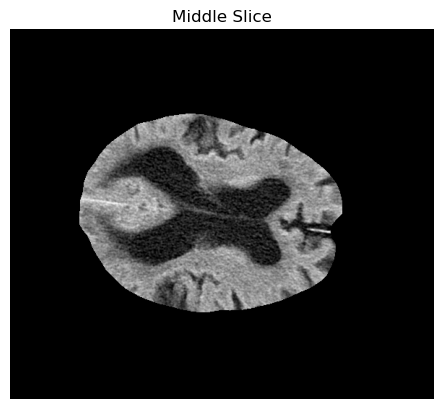

In [194]:
import matplotlib.pyplot as plt
plt.imshow(data[:, :, data.shape[2] // 2],cmap='gray')
plt.title('Middle Slice')
plt.axis('off')
plt.show()

In [171]:
# Clip the data to the custom intensity range
mask= nib.load("/home/stud/sazidur/bhome/ELE670_project/scripts/sub-stroke0004_ses-01_brain-msk.nii.gz").get_fdata() > 0
min_intensity = 0
max_intensity = 90
data_clipped = np.clip(data, min_intensity, max_intensity)
data_clipped[~mask] = 0
data_clipped[data == 0] = 0
    # Normalize the data to [0, 1] range
data_clipped[data_clipped > 0.0001] -= min_intensity
data_normalized = data_clipped / (max_intensity - min_intensity)

    # Apply 3D histogram equalization
equalized_data = exposure.equalize_hist(data_normalized, mask=(data_normalized > 0.0001))
    
equalized_data[data_normalized < 0.0001] = 0
     
    # Save the result as a new NIfTI file
equalized_img = nib.Nifti1Image(equalized_data, img.affine, img.header)

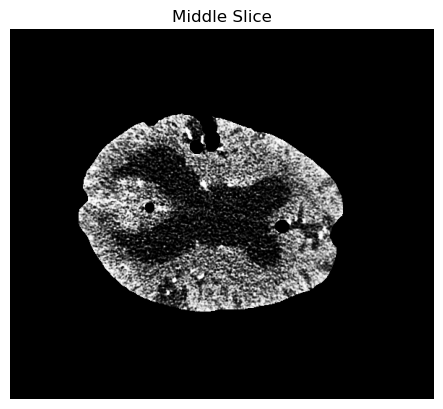

In [172]:
import matplotlib.pyplot as plt
plt.imshow(equalized_img.get_fdata()[:, :, equalized_img.shape[2] // 2],cmap='gray')
plt.title('Middle Slice')
plt.axis('off')
plt.show()

### PREDICTION

In [4]:
import nibabel as nib
import numpy as np
from skimage import exposure

In [19]:
pat = nib.load("/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/imagesTs/case_0187_0000.nii.gz")
# pat = nib.load("/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset100_ISLES24_5ch_f/imagesTr/case_0002_0001.nii.gz")
pred = nib.load("/home/stud/sazidur/bhome/ELE670_project/preds_001_fullres/case_0187.nii.gz")
gt = nib.load("/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/labelsTs/case_0187.nii.gz")

In [20]:
pat.shape

(512, 512, 79)

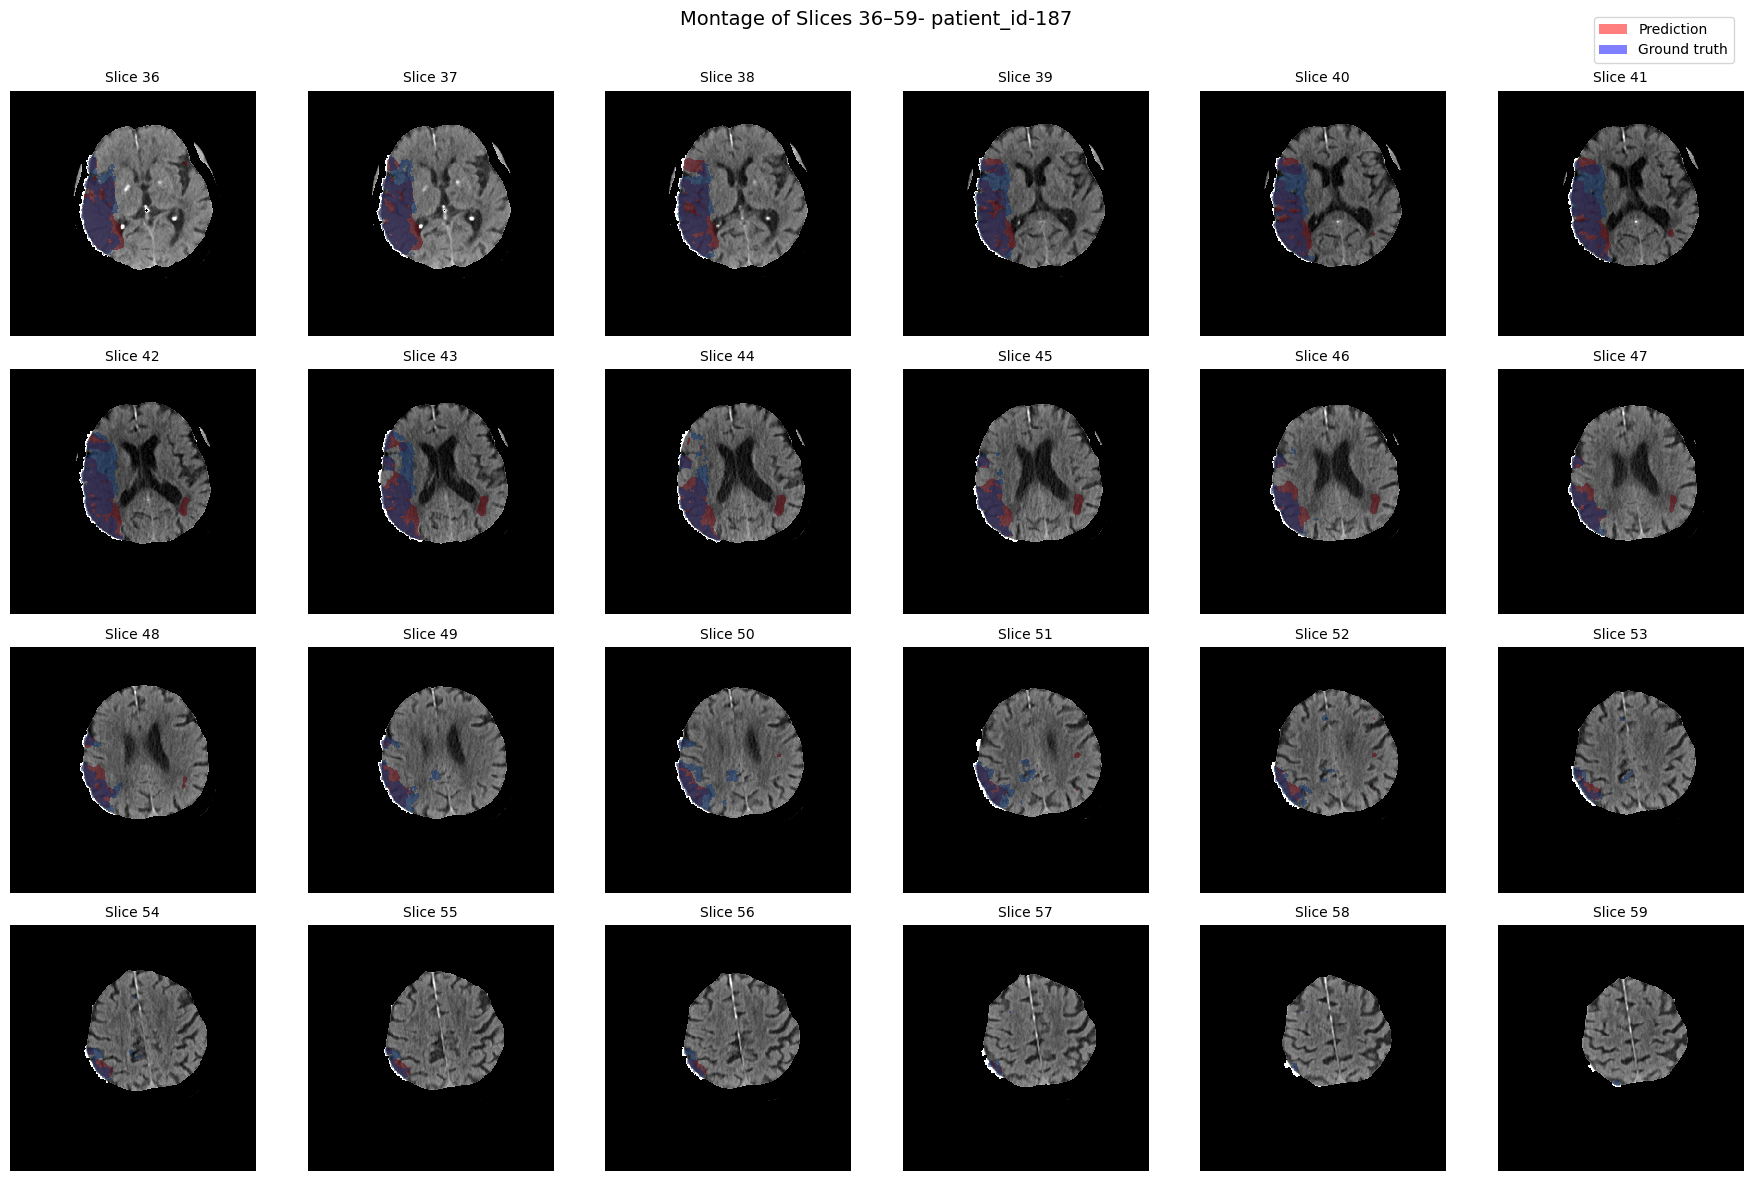

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- data ---
pat_data = pat.get_fdata()
pred_data = pred.get_fdata()
gt_data   = gt.get_fdata()

# --- slice range (inclusive) ---
start, end = 36, 59
idxs = list(range(start, end + 1))
n = len(idxs)

# --- montage grid ---
cols = 6
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
axes = np.array(axes).reshape(rows, cols)  # ensure 2D

for k, sl in enumerate(idxs):
    ax = axes.flat[k]

    # base image (rotate 90° CCW)
    ax.imshow(np.rot90(pat_data[:, :, sl], k=1), cmap='gray', interpolation='none')

    # overlay prediction in red (masked where <=0)
    pred_mask = np.ma.masked_where(pred_data[:, :, sl] <= 0, pred_data[:, :, sl])
    ax.imshow(np.rot90(pred_mask, k=1), cmap='Reds', alpha=0.5, vmin=0, vmax=1, interpolation='none')

    # overlay ground truth in blue (masked where <=0)
    gt_mask = np.ma.masked_where(gt_data[:, :, sl] <= 0, gt_data[:, :, sl])
    ax.imshow(np.rot90(gt_mask, k=1), cmap='Blues', alpha=0.5, vmin=0, vmax=1, interpolation='none')

    ax.set_title(f"Slice {sl}", fontsize=10)
    ax.axis('off')

# hide any unused subplots
for k in range(n, rows * cols):
    fig.delaxes(axes.flat[k])

# legend (red = prediction, blue = ground truth)
handles = [
    Patch(facecolor='red',  alpha=0.5, label='Prediction'),
    Patch(facecolor='blue', alpha=0.5, label='Ground truth'),
]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.98), frameon=True)

# title + layout
fig.suptitle(f"Montage of Slices {start}–{end}- patient_id-187", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave room for suptitle/legend
plt.show()

# optional: save for the report
fig.savefig("montage_slices_36_59.png", dpi=300, bbox_inches='tight')


### Preprocessing

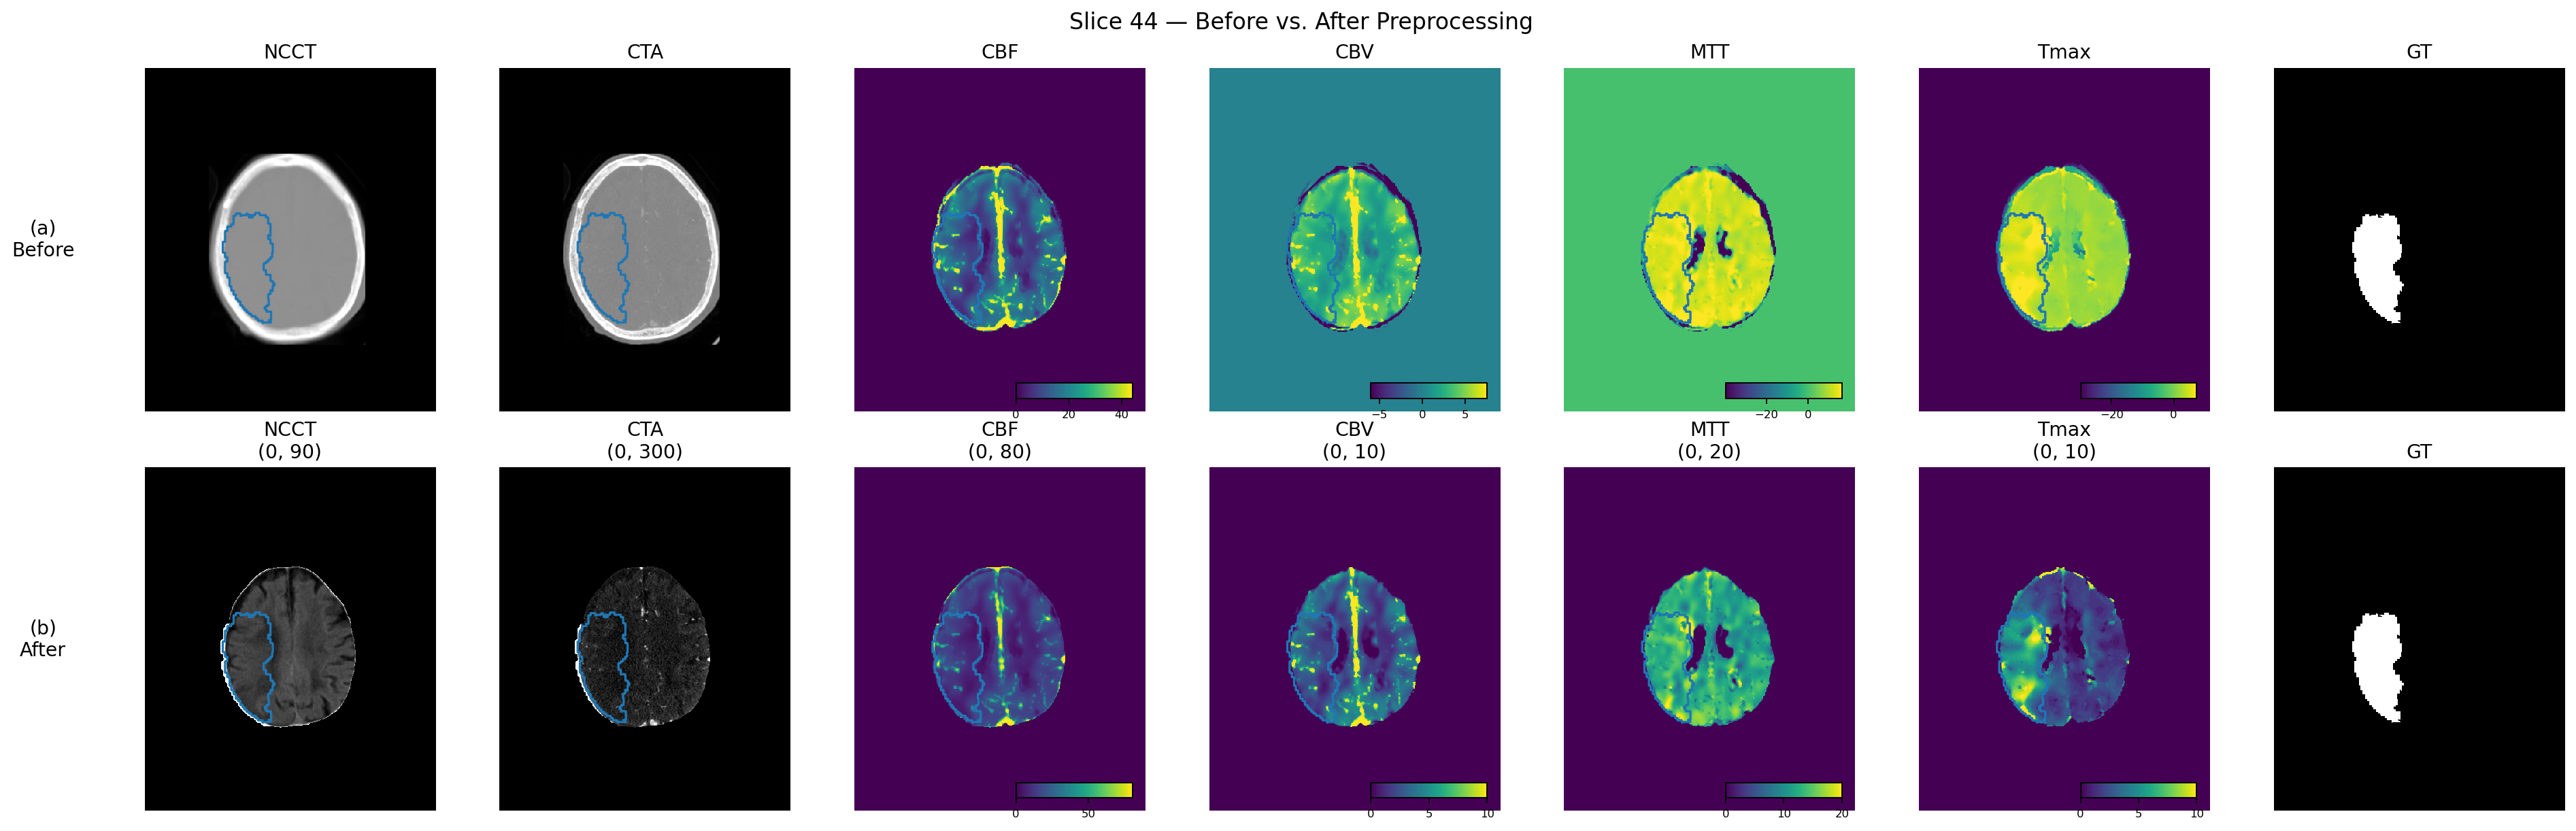

In [142]:
# Bigger, clearer BEFORE vs AFTER figure (orientation fixed, nicer perfusion viz)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pathlib import Path

# ----------------------- SIZE / STYLE -----------------------
PANEL_W = 3.2    # inches per subplot (width)
PANEL_H = 3.5    # inches per subplot (height)
DPI     = 170    # figure DPI
TITLE_FT = 12
ROWLABEL_FT = 12

# ----------------------- USER PATHS -----------------------
BEFORE = {
    "ncct": "/home/stud/sazidur/bhome/test/isles24_train-1/raw_data/sub-stroke0002/ses-01/sub-stroke0002_ses-01_ncct.nii.gz",
    "cta":  "/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0002/ses-01/sub-stroke0002_ses-01_space-ncct_cta.nii.gz",
    "cbf":  "/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0002/ses-01/perfusion-maps/sub-stroke0002_ses-01_space-ncct_cbf.nii.gz",
    "cbv":  "/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0002/ses-01/perfusion-maps/sub-stroke0002_ses-01_space-ncct_cbv.nii.gz",
    "mtt":  "/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0002/ses-01/perfusion-maps/sub-stroke0002_ses-01_space-ncct_mtt.nii.gz",
    "tmax": "/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0002/ses-01/perfusion-maps/sub-stroke0002_ses-01_space-ncct_tmax.nii.gz",
    "gt":   "/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0002/ses-02/sub-stroke0002_ses-02_lesion-msk.nii.gz",
}
AFTER = {
    "ncct": "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/imagesTr/case_0002_0000.nii.gz",
    "cta":  "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/imagesTr/case_0002_0001.nii.gz",
    "cbv":  "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/imagesTr/case_0002_0002.nii.gz",
    "cbf":  "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/imagesTr/case_0002_0003.nii.gz",
    "mtt":  "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/imagesTr/case_0002_0004.nii.gz",
    "tmax": "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/imagesTr/case_0002_0005.nii.gz",
    "gt":   "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset001_ISLES24_6ch_f/labelsTr/case_0002.nii.gz",
}

WINDOWS = {"ncct": (0, 90), "cta": (0, 300), "cbf": (0, 80), "cbv": (0, 10), "mtt": (0, 20), "tmax": (0, 10)}
CHANNELS = [("ncct","NCCT"), ("cta","CTA"), ("cbf","CBF"), ("cbv","CBV"), ("mtt","MTT"), ("tmax","Tmax"), ("gt","GT")]
USE_ORIGIN_LOWER = True
ROTATE_180 = False
SLICE_IDX = None

# ----------------------- HELPERS -----------------------
def load_nii(path):
    img = sitk.ReadImage(str(path)); arr = sitk.GetArrayFromImage(img)  # z,y,x
    return img, arr

def pick_slice_with_label(label_arr):
    zsum = label_arr.reshape(label_arr.shape[0], -1).sum(1)
    nz = np.where(zsum > 0)[0]
    return (label_arr.shape[0] // 2) if len(nz) == 0 else nz[np.argmax(zsum[nz])]

def robust_range(a, lo=1, hi=99):
    v = a[np.isfinite(a)]
    return (0, 1) if v.size == 0 else tuple(np.percentile(v, [lo, hi]))

def orient2d(a):
    return np.rot90(a, 2) if ROTATE_180 else a

def draw_panel(ax, img2d, title="", cmap="gray", vmin=None, vmax=None, overlay=None, add_cbar=False):
    im = ax.imshow(img2d, cmap=cmap, vmin=vmin, vmax=vmax,
                   origin=("lower" if USE_ORIGIN_LOWER else "upper"), interpolation="nearest")
    if overlay is not None:
        # crisp contour instead of scatter
        ax.contour(overlay, levels=[0.5], colors="C0", linewidths=1.4, origin=("lower" if USE_ORIGIN_LOWER else "upper"))
    ax.set_title(title, fontsize=TITLE_FT)
    ax.axis("off")
    if add_cbar:
        cax = inset_axes(ax, width="40%", height="4.5%", loc="lower right", borderpad=0.8)
        cb = plt.colorbar(im, cax=cax, orientation="horizontal")
        cb.ax.tick_params(labelsize=7)

def to_uint8_window(a, vmin, vmax):
    a = np.clip(a, vmin, vmax)
    a = (a - vmin) / (vmax - vmin) if vmax > vmin else np.zeros_like(a)
    return (a * 255).astype(np.uint8)

# ----------------------- LOAD -----------------------
imgB, arrB = {}, {}
for k, p in BEFORE.items():
    assert Path(p).exists(), f"Missing BEFORE file: {p}"
    imgB[k], arrB[k] = load_nii(p)

imgA, arrA = {}, {}
for k, p in AFTER.items():
    assert Path(p).exists(), f"Missing AFTER file: {p}"
    imgA[k], arrA[k] = load_nii(p)

# ----------------------- SLICE -----------------------
if SLICE_IDX is None:
    SLICE_IDX = pick_slice_with_label(arrB["gt"])

B2D = {k: arrB[k][SLICE_IDX] for k in arrB}
A2D = {k: arrA[k][SLICE_IDX] for k in arrA}

# binary GT, orientation fix
for d in (B2D, A2D):
    d["gt"] = (d["gt"] > 0).astype(np.uint8)
    for k in d:
        d[k] = orient2d(d[k])

edge = A2D.get("gt", B2D["gt"])  # use GT as a mask for contour

# ----------------------- PLOT -----------------------
n_cols = len(CHANNELS)
fig, axes = plt.subplots(2, n_cols,
                         figsize=(PANEL_W*n_cols, PANEL_H*2),
                         dpi=DPI, constrained_layout=True)

# BEFORE row
vmin_ncct, vmax_ncct = robust_range(B2D["ncct"])
vmin_cta,  vmax_cta  = robust_range(B2D["cta"])

for j, (k, label) in enumerate(CHANNELS):
    ax = axes[0, j]
    if k == "gt":
        draw_panel(ax, B2D["gt"]*255, title="GT", cmap="gray")
    elif k in ["ncct","cta"]:
        vmin, vmax = (vmin_ncct, vmax_ncct) if k=="ncct" else (vmin_cta, vmax_cta)
        draw_panel(ax, to_uint8_window(B2D[k], vmin, vmax), title=label, cmap="gray", overlay=edge)
    else:
        vmin, vmax = robust_range(B2D[k], 1, 99)
        draw_panel(ax, B2D[k], title=label, cmap="viridis", vmin=vmin, vmax=vmax, overlay=edge, add_cbar=True)

axes[0,0].text(-0.35, 0.5, "(a)\nBefore", va="center", ha="center",
               fontsize=ROWLABEL_FT, transform=axes[0,0].transAxes)

# AFTER row
for j, (k, label) in enumerate(CHANNELS):
    ax = axes[1, j]
    if k == "gt":
        draw_panel(ax, A2D["gt"]*255, title="GT", cmap="gray")
    elif k in ["ncct","cta"]:
        vmin, vmax = WINDOWS[k]
        draw_panel(ax, to_uint8_window(A2D[k], vmin, vmax), title=f"{label}\n({vmin}, {vmax})",
                   cmap="gray", overlay=edge)
    else:
        vmin, vmax = WINDOWS[k]
        draw_panel(ax, A2D[k], title=f"{label}\n({vmin}, {vmax})",
                   cmap="viridis", vmin=vmin, vmax=vmax, overlay=edge, add_cbar=True)

axes[1,0].text(-0.35, 0.5, "(b)\nAfter", va="center", ha="center",
               fontsize=ROWLABEL_FT, transform=axes[1,0].transAxes)

fig.suptitle(f"Slice {SLICE_IDX} — Before vs. After Preprocessing", fontsize=14)
plt.show()
